In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

from utils import (
    detrend, standardize, reg_slope, monthly_anomalies
)

In [2]:
eq = dict(lat=0,lon=slice(140,260))

#### 1.1 NEMO SSH 

In [3]:
t_grid_file = xr.open_zarr('data/ORCA025.L46-KFS006_TroPA.zarr')
ssh_fitting = t_grid_file.sossheig.sel(**eq)

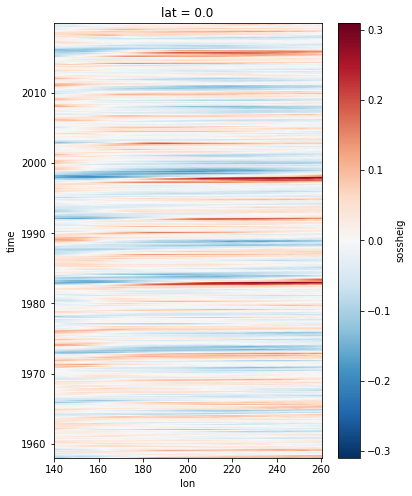

In [4]:
ssh_nemo_eq = detrend(monthly_anomalies(ssh_fitting).compute())
plt.figure(figsize=(6, 8))
ssh_nemo_eq.T.plot()

#### 1.2 linear SSH 

In [5]:
eta = xr.open_zarr('data/lmmm_eta_nemo.zarr').eta
eta_fitting = (
    eta
    .assign_coords(
        {'time': (eta.time-np.timedelta64(1314900,'s')).data}
    )
    .sel(lon=eq["lon"])
    .interp(lat=0., time=ssh_nemo_eq.time)
    .fillna(0.)
    .compute()
)

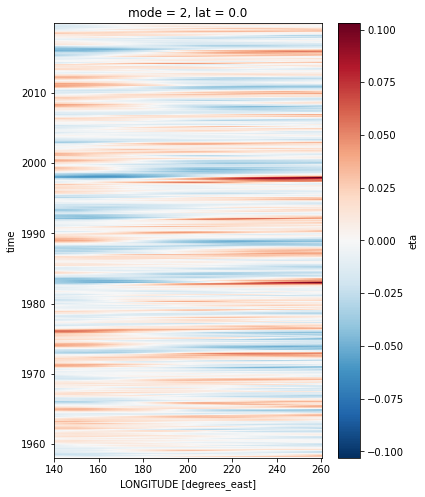

In [6]:
plt.figure(figsize=(6, 8))
eta_fitting.sel(mode=2).plot();

In [7]:
# fit to full data
def extract_data(t_slice, max_mode=10):
    X = (
        eta_fitting
        .isel(time=t_slice, mode=slice(max_mode))
        .stack(sample=("time", "lon"))
        .T
    )
    y = (
        ssh_nemo_eq
        .isel(time=t_slice)
        .stack(sample=("time", "lon"))
    )
    return X, y

In [8]:
coef = np.zeros((len(eta_fitting.mode), len(eta_fitting.mode)))
for i, max_mode in enumerate(range(1, 11)):
    X, y = extract_data(slice(743), max_mode)
    reg = LinearRegression(fit_intercept=False).fit(X, y)
    coef[i, :max_mode] = reg.coef_    
with np.printoptions(precision=3, suppress=True):
    print(coef)

[[ 2.329  0.     0.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.679  2.195  0.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.824  1.457  0.789  0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.866  1.487  0.435  0.355  0.     0.     0.     0.     0.     0.   ]
 [ 0.873  1.501  0.525 -0.059  0.357  0.     0.     0.     0.     0.   ]
 [ 0.873  1.491  0.549 -0.189  0.76  -0.307  0.     0.     0.     0.   ]
 [ 0.87   1.518  0.562 -0.338  1.607 -1.853  0.873  0.     0.     0.   ]
 [ 0.853  1.547  0.641 -0.368  0.962 -0.06  -1.915  1.651  0.     0.   ]
 [ 0.85   1.548  0.654 -0.382  1.085 -0.386 -1.107  0.398  0.674  0.   ]
 [ 0.847  1.55   0.65  -0.336  0.936 -0.016 -2.465  4.179 -4.265  2.296]]


In [9]:
mod1 = coef[2,0]*eta_fitting.sel(mode=1)
mod2 = coef[2,1]*eta_fitting.sel(mode=2)
mod3 = coef[2,2]*eta_fitting.sel(mode=3)
m3=(mod1+mod2+mod3)*-1

In [10]:
ssh_lin_eq = detrend(m3)

#### 1.3 D20 data 

In [11]:
d20_mon_anom = monthly_anomalies(
    (-1) * t_grid_file.d20.sel(**eq)
)
d20_mon_anom.attrs.update({"long_name": "D20 anomaly", "units": "m"})

d20_eq = detrend(
    d20_mon_anom.fillna(0.).compute()
).rename('D20')

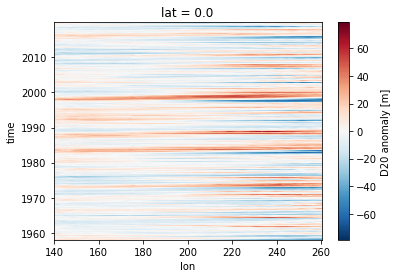

In [12]:
d20_eq.T.plot()

### 2. create NLTI

#### 2.1 NEMO-NLTI

In [13]:
nemo_nlti = xr.open_zarr("data_fig3.zarr/").NLTI.sel(lon=eq["lon"])

#### 2.2 linear version 1-NLTI

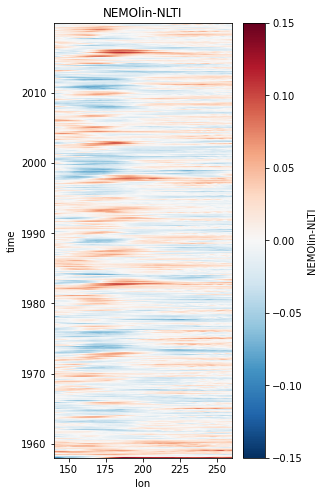

In [14]:
slope = reg_slope(ssh_lin_eq, ssh_nemo_eq, dim="time")

nemolin_nlti = (
    ssh_nemo_eq - slope * ssh_lin_eq
).rename("NEMOlin-NLTI")

nemolin_nlti=detrend(
    nemolin_nlti
)

plt.figure(figsize=(4, 8))
nemolin_nlti.T.plot(vmin=-0.15,vmax=0.15,cmap=plt.cm.RdBu_r)
plt.title("NEMOlin-NLTI");

## Write outout

In [15]:
!rm -rf data_fig4.zarr

xr.Dataset(
    dict(
        nemo_nlti=nemo_nlti,
        nemolin_nlti=nemolin_nlti,
    )
).to_zarr("data_fig4.zarr");